In [ ]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

data21584


In [22]:
#包版本
!pip freeze

absl-py==0.8.1
aspy.yaml==1.3.0
attrs==19.2.0
audioread==2.1.8
backcall==0.1.0
bleach==3.1.0
cachetools==4.0.0
certifi==2019.9.11
cffi==1.14.0
cfgv==2.0.1
chardet==3.0.4
Click==7.0
cloudpickle==1.2.1
cma==2.7.0
colorlog==4.1.0
cycler==0.10.0
Cython==0.29
decorator==4.4.0
entrypoints==0.3
flake8==3.7.9
Flask==1.1.1
funcsigs==1.0.2
future==0.18.0
google-auth==1.10.0
google-auth-oauthlib==0.4.1
graphviz==0.13
grpcio==1.26.0
gunicorn==20.0.4
gym==0.12.1
h5py==2.9.0
identify==1.4.10
idna==2.8
imageio==2.6.1
imageio-ffmpeg==0.3.0
importlib-metadata==0.23
ipykernel==5.1.0
ipython==7.0.1
ipython-genutils==0.2.0
itsdangerous==1.1.0
jedi==0.15.1
jieba==0.42.1
Jinja2==2.10.1
joblib==0.14.1
jsonschema==3.1.1
jupyter-client==5.3.3
jupyter-core==4.5.0
kiwisolver==1.1.0
librosa==0.7.2
lightgbm==2.3.1
llvmlite==0.31.0
Markdown==3.1.1
MarkupSafe==1.1.1
matplotlib==2.2.3
mccabe==0.6.1
mistune==0.8.4
more-itertools==7.2.0
moviepy==1.0.1
nbconvert==5.3.1
nbformat==4.4.0
networkx==2.4
nltk==3.4.5
nodeenv==

In [1]:
#安装lightgbm
!pip install lightgbm

In [2]:
#导入必要的包
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold,cross_val_score,StratifiedKFold
from sklearn.metrics import roc_auc_score
import gc
import lightgbm as lgb
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [3]:
#导入数据
df_train =pd.read_csv('data/data24240/train_0312.csv')
df_test =pd.read_csv('data/data24240/test_0312.csv')
df_sub =pd.read_csv('data/data24240/submit_0312.csv')

In [4]:
df_feature = pd.concat([df_train, df_test], sort=False)

In [5]:
df_feature.columns = ['ID', 'max_phase', 'weight', 'RO5', 'AlogP', 'Features', 'Label']

In [6]:
#提取小分子矢量中的特征
df_Features = df_feature[['ID', 'Features']].copy(deep=True)
df_Features['Features'] = df_feature['Features'].apply(lambda x: x[1:-1])
df_temp = df_Features['Features'].str.split(',', expand=True)

np_temp = df_temp.values
np_temp = np_temp.astype(np.float64)

df_temp = pd.DataFrame(np_temp)
df_temp.columns = ['Features_{}'.format(i) for i in range(df_temp.shape[1])]

df_feature = df_feature.reset_index(drop=True)
df_feature = pd.concat([df_feature, df_temp], axis=1)

del np_temp, df_temp, df_Features
gc.collect()

34

In [7]:
#将偏度较大的特征正态化
df_feature['weight'] = np.log1p(df_feature['weight'])
df_feature['AlogP'] = np.log1p(df_feature['AlogP'])

In [8]:
#提取小分子矢量中的01矢量特征
def func(x):
    a = x[1:-1].split(',')
    a = [float(i) for i in a if i=='0' or i=='1']
    return a

df_feature['Features'] = df_feature['Features'].apply(func)

In [9]:
#针对01矢量特征做的一些信息提取
df_feature['Features_sum'] = df_feature['Features'].apply(lambda x: sum(x))
df_feature['Features_mean'] = df_feature['Features'].apply(lambda x: np.mean(x))
df_feature['Features_0_count']=df_feature['Features'].apply(lambda x:len([i for i in x if i==0]))
df_feature['Features_1_count']=df_feature['Features'].apply(lambda x:len([i for i in x if i==1]))

In [10]:
df_test = df_feature[df_feature['Label'].isnull()].copy()
df_train = df_feature[df_feature['Label'].notnull()].copy()

In [11]:
#对分子相位特征进行one_hot处理
cat_list1=[ 'max_phase']
df_train=pd.get_dummies(df_train,columns=cat_list1,drop_first=True,sparse=True)
df_test=pd.get_dummies(df_test,columns=cat_list1,drop_first=True,sparse=True)

In [12]:
#去掉ID以及小分子01矢量列表
label=df_train['Label']
df_train.drop(['Features','ID','Label'],axis=1,inplace=True)
df_test.drop(['Features','ID','Label'],axis=1,inplace=True)

In [13]:
#填补缺失值（以均值进行填补）
from sklearn.preprocessing import Imputer
imr = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0 )
for i in ['AlogP','Features_3159','Features_3158','Features_3157','Features_3156','RO5']:
    imr = imr.fit(df_train[i].values.reshape(-1, 1))
    df_train[i] = imr.transform(df_train[i].values.reshape(-1, 1))
    df_test[i] = imr.transform(df_test[i].values.reshape(-1, 1))

In [14]:
#去掉方差为0的特征
drop_list=[]
for i in [j for j in df_train.columns]:
    if df_train[i].std()==0:
        drop_list.append(i)

df_train.drop(drop_list,axis=1,inplace=True)
df_test.drop(drop_list,axis=1,inplace=True)

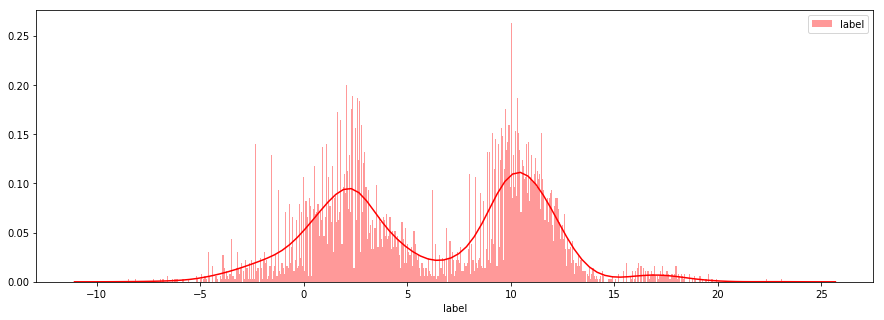

In [15]:
#绘制label分布图（可看出阈值7以左为1类，阈值7以右为一类）
plt.figure(figsize=(15,5))
sns.distplot(label.tolist(),color='r',label='label',bins=600,hist=True, kde=True)
plt.xlabel('label')
plt.legend()
plt.show()

In [15]:
#标注上述的二分类label,命名为new_label
def biaozhu(x):
    if x<7:
        y=0
    else:
        y=1
    return y
new_label=label.map(biaozhu)

In [16]:
#删除非二值特征中的冗余特征
xian_list=['Features_3151','Features_3155','Features_3161','Features_3162','Features_3158','Features_3153','Features_3154','Features_25','Features_3163','Features_27']
df_train.drop(xian_list,axis=1,inplace=True)
df_test.drop(xian_list,axis=1,inplace=True)

In [18]:
def lgb_class_train(pout_train,test_df,target):
    folds=StratifiedKFold(n_splits=10, shuffle=True, random_state=666)
    oof=np.zeros(len(pout_train))
    feature_importance_df=pd.DataFrame()
    predictions=np.zeros(len(test_df))
    
    param={'num_leaves': 31,
             'objective': 'binary',
             'max_depth': -1,
             'learning_rate': 0.01,
             "boosting": "gbdt",
             "subsample": 0.9,
             "subsample_freq": 10,
             "reg_alpha":1e-05,
             'n_estimators':1500,
             "metric": 'auc',
             "reg_lambda": 0.3,
             "verbosity": -1,
             'is_unbalance':True,
             "random_state": 666}
    
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(pout_train.values,target)):
        
        print("Fold {}".format(fold_))
        trn_data=lgb.Dataset(pout_train.values[trn_idx],label=target[trn_idx])
        val_data=lgb.Dataset(pout_train.values[val_idx],label=target[val_idx])
        #categorical_feature_list=[i for i in range(len(pout_train.columns)) if pout_train.columns[i] in cate_list]
        
        num_round=100000
        clf=lgb.train(param,trn_data,num_round,valid_sets=[trn_data,val_data],verbose_eval=200,
        early_stopping_rounds=300)
        oof[val_idx]=clf.predict(pout_train.values[val_idx],num_iteration=clf.best_iteration)
        predictions+=clf.predict(test_df.values,num_iteration=clf.best_iteration)/folds.n_splits
        fold_importance_df=pd.DataFrame()
        fold_importance_df["Feature"]=pout_train.columns
        fold_importance_df["importance"]=clf.feature_importance()
        fold_importance_df["fold"]=fold_+1
        feature_importance_df=pd.concat([feature_importance_df, fold_importance_df],axis=0)
    print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

    cols=(feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:150].index)
    best_features=feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
    
    plt.figure(figsize=(14,30))
    sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
    plt.title('Features importance (averaged/folds)')
    plt.tight_layout()
    plt.show()
    return oof,predictions

Fold 0
Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.974178	valid_1's auc: 0.946958
[400]	training's auc: 0.988458	valid_1's auc: 0.963589
[600]	training's auc: 0.994685	valid_1's auc: 0.969831
[800]	training's auc: 0.997082	valid_1's auc: 0.972664
[1000]	training's auc: 0.998176	valid_1's auc: 0.974131
[1200]	training's auc: 0.998775	valid_1's auc: 0.975573
[1400]	training's auc: 0.999101	valid_1's auc: 0.975715
Did not meet early stopping. Best iteration is:
[1500]	training's auc: 0.999206	valid_1's auc: 0.975831
Fold 1
Training until validation scores don't improve for 300 rounds
[200]	training's auc: 0.975923	valid_1's auc: 0.952654
[400]	training's auc: 0.989506	valid_1's auc: 0.960968
[600]	training's auc: 0.995289	valid_1's auc: 0.964568
[800]	training's auc: 0.99753	valid_1's auc: 0.966685
[1000]	training's auc: 0.998609	valid_1's auc: 0.968418
[1200]	training's auc: 0.999087	valid_1's auc: 0.968727
[1400]	training's auc: 0.999317	valid_1

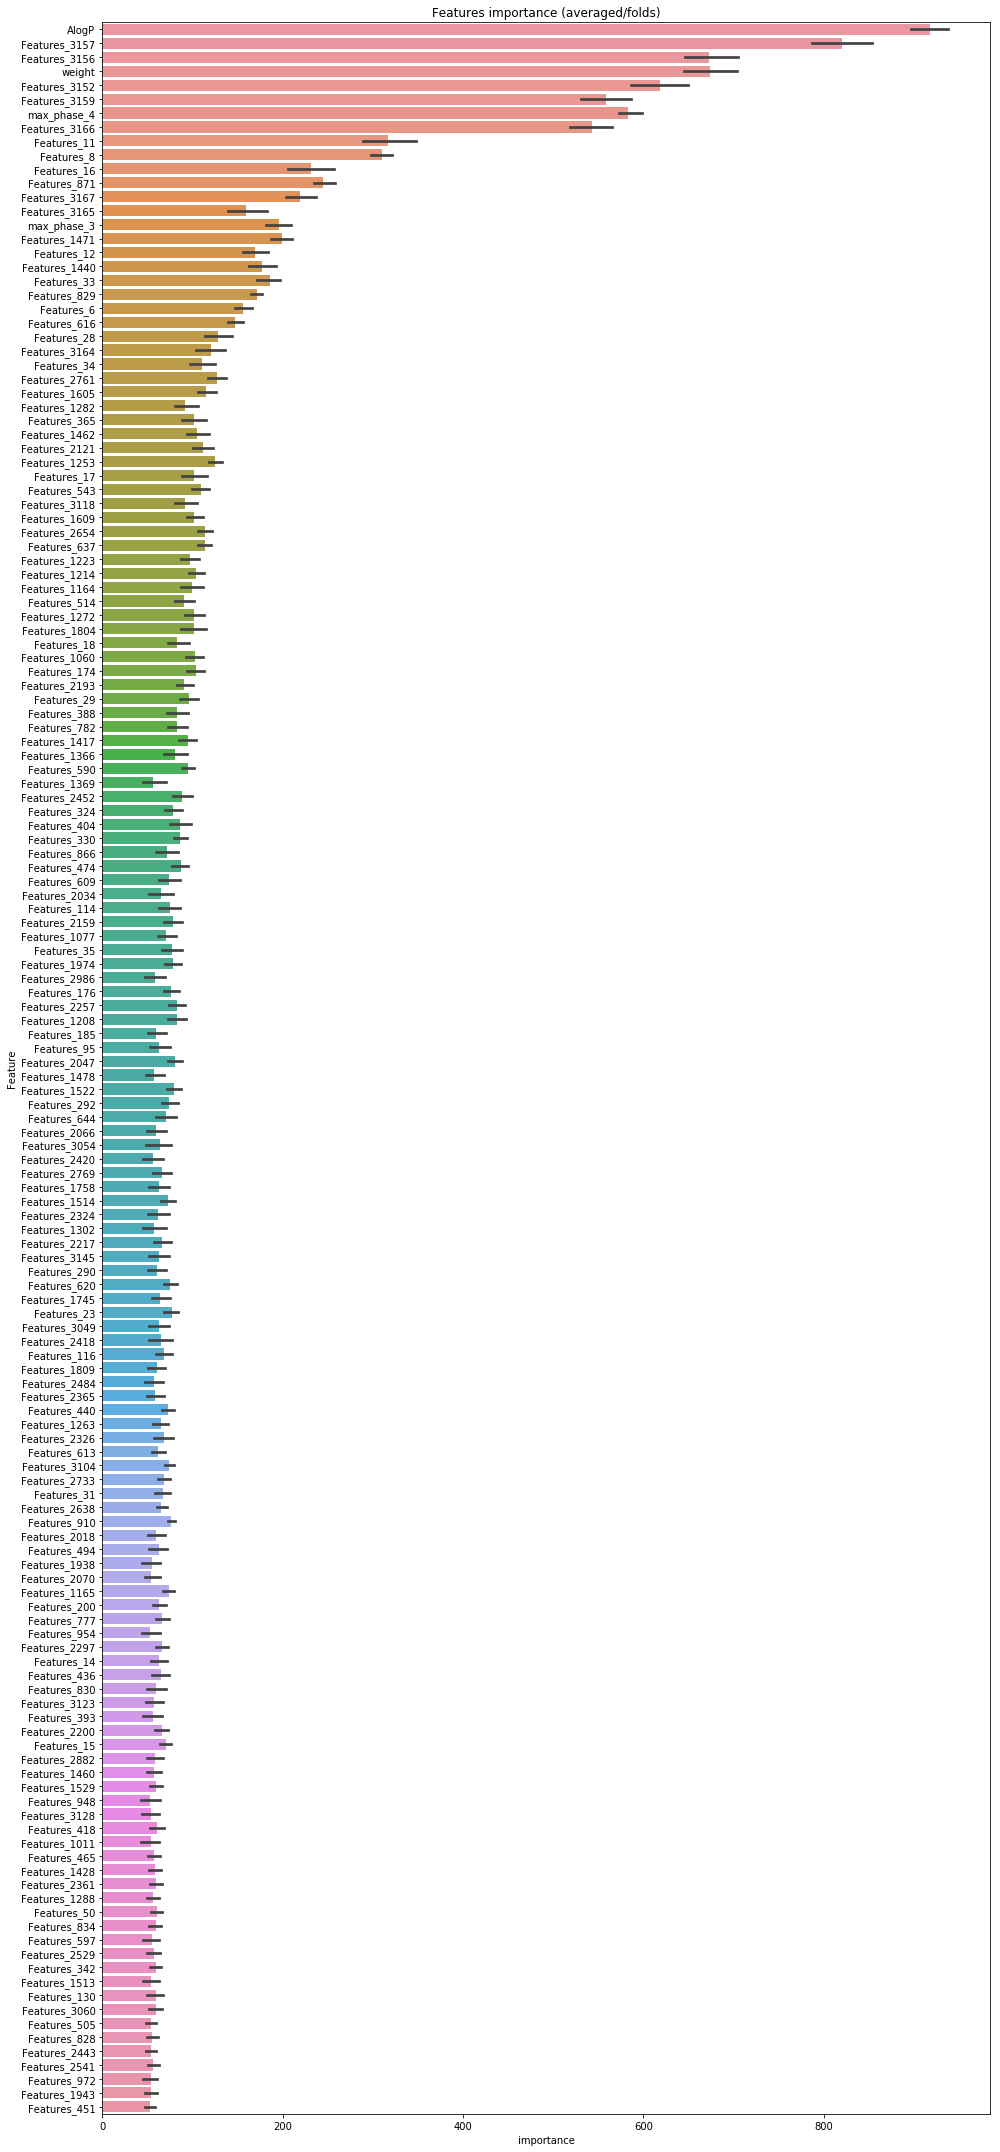

In [19]:
#利用数据来源俩个不同的分布的特点进行训练
train_oof,test_pre=lgb_class_train(df_train,df_test,new_label)

In [20]:
#将数据属于new_label类别1的概率作为新的特征
df_train['sign']=train_oof
df_test['sign']=test_pre

In [ ]:
#计算rmse
def calc_rmse(y_pred, y_true):
    return np.sqrt(((y_pred - y_true) ** 2).mean())

In [17]:
#lgb回归模型
def lgb_train(pout_train, test_df,target):
    folds = KFold(n_splits=10, shuffle=True, random_state=2020)
    oof = np.zeros((len(pout_train)))
    feature_importance_df = pd.DataFrame()
    predictions = np.zeros((len(test_df)))

    param = {'boosting_type': 'gbdt','num_leaves': 31,'min_data_in_leaf': 20,
             'objective': 'regression','max_depth': -1,'learning_rate': 0.01,
             "min_child_samples": 20,"feature_fraction": 0.4,"bagging_freq": 1,
             "bagging_fraction": 0.9,"bagging_seed": 11,"metric": 'rmse',
             "lambda_l1": 0.1,"lambda_l2": 0.3,"verbosity": -1}
         
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(pout_train.values, target)):
        print("Fold {}".format(fold_))
        trn_data = lgb.Dataset(pout_train.values[trn_idx], label=target.values[trn_idx])
        val_data = lgb.Dataset(pout_train.values[val_idx], label=target.values[val_idx])

        num_round = 10000
        '''clf = lgb.train(param, trn_data, num_round, valid_sets=[trn_data, val_data], verbose_eval=300,feval=get_SMAPE,
                        early_stopping_rounds=400)'''
        clf = lgb.train(param, trn_data, num_round, valid_sets=[trn_data, val_data], verbose_eval=100,
                        early_stopping_rounds=300)
        oof[val_idx] = clf.predict(pout_train.values[val_idx], num_iteration=clf.best_iteration)
        predictions += clf.predict(test_df.values, num_iteration=clf.best_iteration) / folds.n_splits
        fold_importance_df=pd.DataFrame()
        fold_importance_df["Feature"]=pout_train.columns
        fold_importance_df["importance"]=clf.feature_importance()
        fold_importance_df["fold"]=fold_+1
        feature_importance_df=pd.concat([feature_importance_df, fold_importance_df],axis=0)
    print("CV score: {:<8.8f}".format(calc_rmse(oof,target.values)))
    
    #保存结果
    df_sub['Label']=predictions
    df_sub.to_csv('work/Result_lgb2.csv',index=False)
    
    cols=(feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:150].index)
    best_features=feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
    
    plt.figure(figsize=(14,30))
    sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
    plt.title('Features importance (averaged/folds)')
    plt.tight_layout()
    plt.show()
    return feature_importance_df

Fold 0
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 3.1514	valid_1's rmse: 3.40623
[200]	training's rmse: 2.4039	valid_1's rmse: 2.71835
[300]	training's rmse: 2.09993	valid_1's rmse: 2.46148
[400]	training's rmse: 1.92132	valid_1's rmse: 2.32675
[500]	training's rmse: 1.81564	valid_1's rmse: 2.26118
[600]	training's rmse: 1.73794	valid_1's rmse: 2.2205
[700]	training's rmse: 1.67364	valid_1's rmse: 2.18982
[800]	training's rmse: 1.61656	valid_1's rmse: 2.16709
[900]	training's rmse: 1.56773	valid_1's rmse: 2.15048
[1000]	training's rmse: 1.52667	valid_1's rmse: 2.13817
[1100]	training's rmse: 1.48963	valid_1's rmse: 2.12715
[1200]	training's rmse: 1.45632	valid_1's rmse: 2.12103
[1300]	training's rmse: 1.42641	valid_1's rmse: 2.11408
[1400]	training's rmse: 1.39937	valid_1's rmse: 2.10895
[1500]	training's rmse: 1.37389	valid_1's rmse: 2.1046
[1600]	training's rmse: 1.34933	valid_1's rmse: 2.10123
[1700]	training's rmse: 1.32652	valid_1's rmse: 

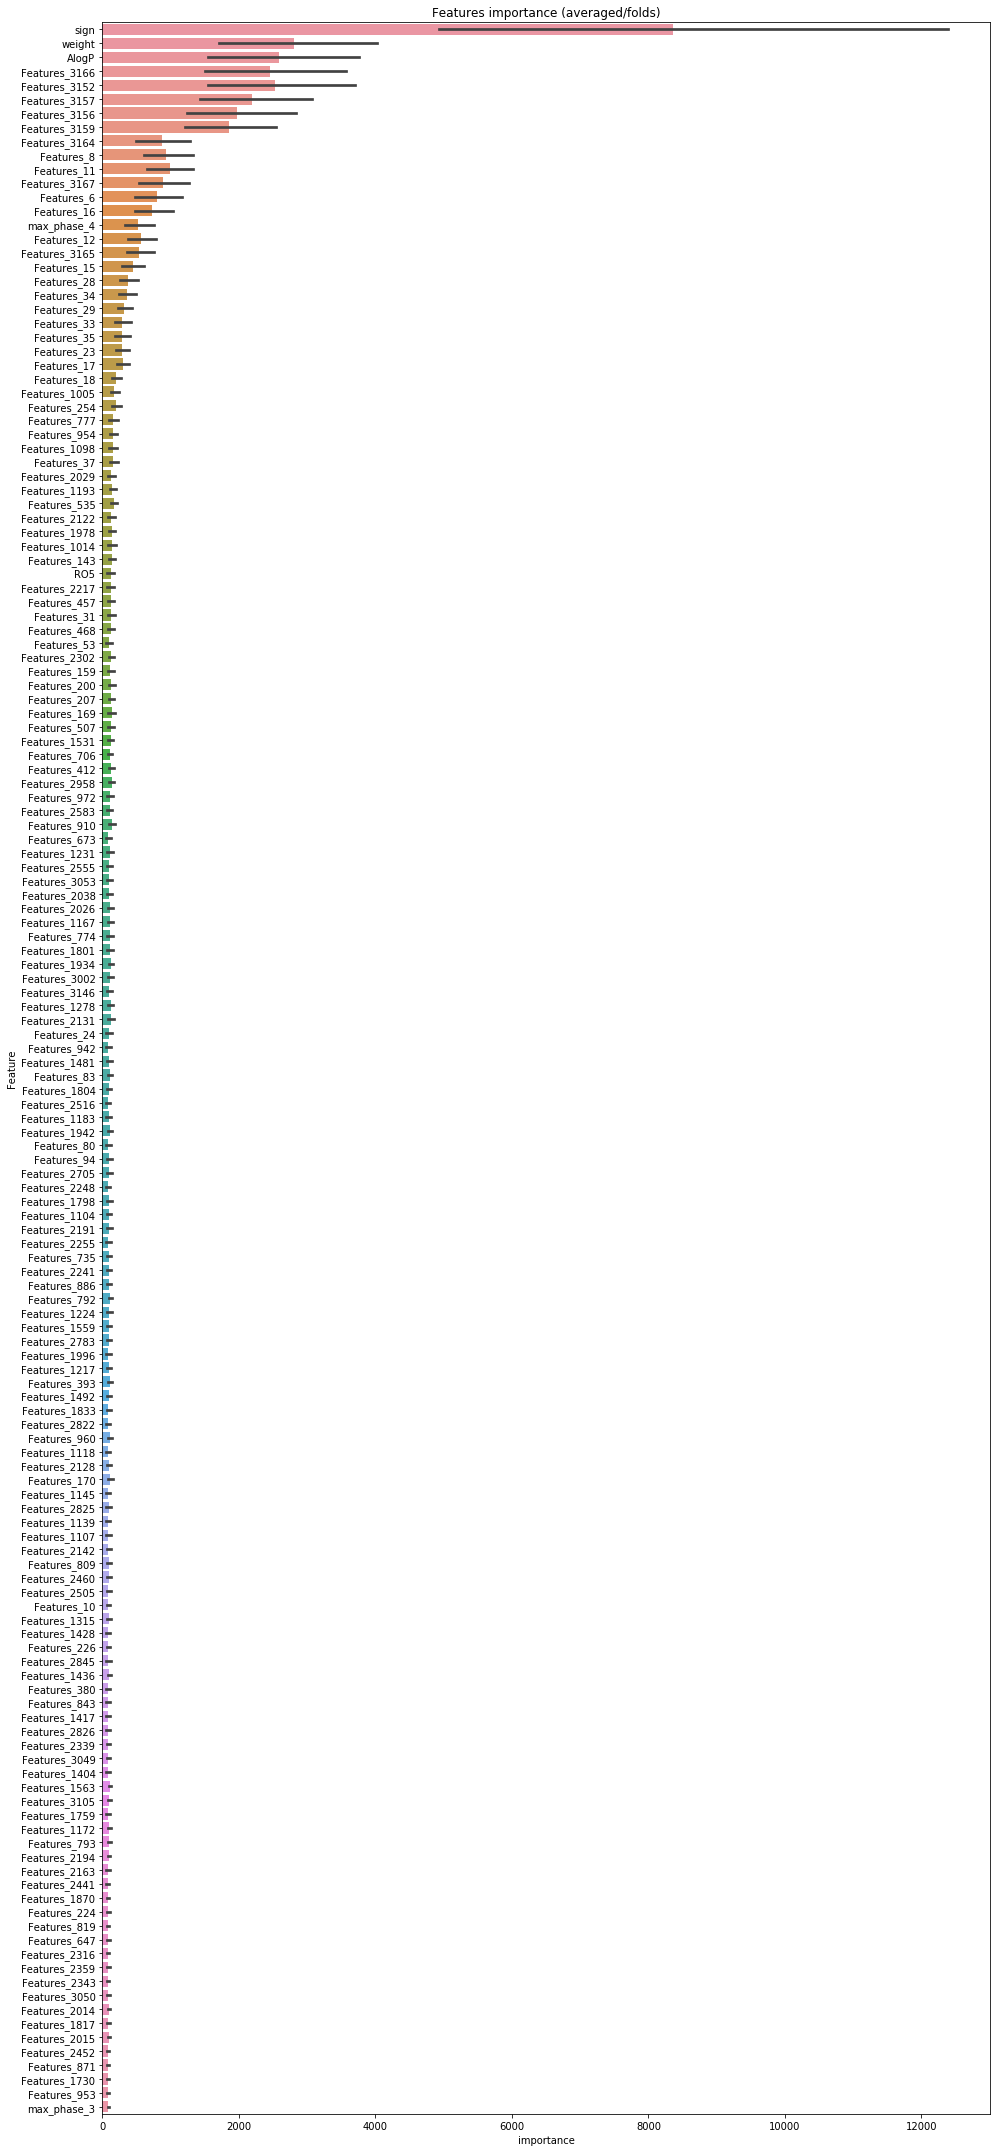

In [21]:
#进行训练，结果保存在'work/Result_lgb2.csv'中
df=lgb_train(df_train, df_test,label)

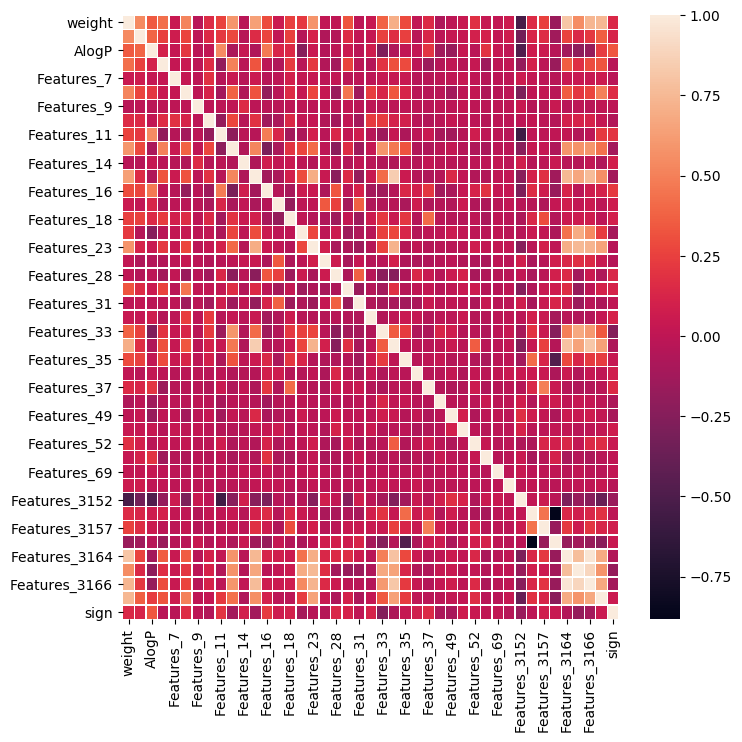

In [23]:
#可视化非二值特征的相关性
num_list=[]
for i in df_train.columns:
    if df_train[i].nunique()>2:
        num_list.append(i)
#绘制相关性热图
fig=plt.figure(dpi=100)
fig.set_size_inches(8,8)
sns.heatmap(df_train[num_list].corr(), linewidths=0.2) 
plt.show()